# Dimension Reduction (and Topics)

Squeezing the data down to be digested easily for modeling and analysis.

In [1]:
from google.colab import drive
drive.mount('/content/drive')  # Add My Drive/<>

import os
os.chdir('drive/My Drive')
os.chdir('Books_Writings/NLPBook/')

Mounted at /content/drive


In [2]:
%%capture
%pylab inline
import pandas as pd
import os
%load_ext rpy2.ipython
from IPython.display import Image

## Dimension Reduction of Text

- We show here that documents end up in a space of two PCs (principal components).

- LDA is a way of reducing documents into a smaller space.

We can use the wine reviews dataset from Kaggle.

https://www.kaggle.com/thebrownviking20/topic-modelling-with-spacy-and-scikit-learn

Dataset: https://www.kaggle.com/thebrownviking20/topic-modelling-with-spacy-and-scikit-learn/data?select=winemag-data-130k-v2.csv

In [3]:
%%time
os.system('wget https://github.com/morisasy/kaggle/raw/master/data/winemag-data-130k-v2.csv')
os.system('mv winemag-data-130k-v2.csv NLP_data/')

CPU times: user 25 ms, sys: 3.85 ms, total: 28.8 ms
Wall time: 4.84 s


0

In [4]:
wineDF = pd.read_csv("NLP_data/winemag-data-130k-v2.csv")
print(wineDF.shape)
wineDF.head()

(129971, 14)


Unnamed: 0   country                                        description  \
0           0     Italy  Aromas include tropical fruit, broom, brimston...   
1           1  Portugal  This is ripe and fruity, a wine that is smooth...   
2           2        US  Tart and snappy, the flavors of lime flesh and...   
3           3        US  Pineapple rind, lemon pith and orange blossom ...   
4           4        US  Much like the regular bottling from 2012, this...   

                          designation  points  price           province  \
0                        Vulkà Bianco      87    NaN  Sicily & Sardinia   
1                            Avidagos      87   15.0              Douro   
2                                 NaN      87   14.0             Oregon   
3                Reserve Late Harvest      87   13.0           Michigan   
4  Vintner's Reserve Wild Child Block      87   65.0             Oregon   

              region_1           region_2         taster_name  \
0                 Etna                NaN       Kerin O’Keefe   
1                  NaN                NaN          Roger Voss   
2    Willamette Valley  Willamette Valley        Paul Gregutt   
3  Lake Michigan Shore                NaN  Alexander Peartree   
4    Willamette Valley  Willamette Valley        Paul Gregutt   

  taster_twitter_handle                                              title  \
0          @kerinokeefe                  Nicosia 2013 Vulkà Bianco  (Etna)   
1            @vossroger      Quinta dos Avidagos 2011 Avidagos Red (Douro)   
2           @paulgwine       Rainstorm 2013 Pinot Gris (Willamette Valley)   
3                   NaN  St. Julian 2013 Reserve Late Harvest Riesling ...   
4           @paulgwine   Sweet Cheeks 2012 Vintner's Reserve Wild Child...   

          variety               winery  
0     White Blend              Nicosia  
1  Portuguese Red  Quinta dos Avidagos  
2      Pinot Gris            Rainstorm  
3        Riesling           St. Julian  
4      Pinot Noir         Sweet Cheeks

In [5]:
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from tqdm import tqdm
import string

In [6]:
%%capture
!pip install spacy
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
!python -m spacy download en_core_web_sm

In [7]:
# Load in the spaCy object, i.e., the language model
nlp = spacy.load('en_core_web_sm')

In [8]:
wineDF.description

0         Aromas include tropical fruit, broom, brimston...
1         This is ripe and fruity, a wine that is smooth...
2         Tart and snappy, the flavors of lime flesh and...
3         Pineapple rind, lemon pith and orange blossom ...
4         Much like the regular bottling from 2012, this...
                                ...                        
129966    Notes of honeysuckle and cantaloupe sweeten th...
129967    Citation is given as much as a decade of bottl...
129968    Well-drained gravel soil gives this wine its c...
129969    A dry style of Pinot Gris, this is crisp with ...
129970    Big, rich and off-dry, this is powered by inte...
Name: description, Length: 129971, dtype: object

In [9]:
# Functions to parse the reviews
punctuations = string.punctuation
stopwords = list(STOP_WORDS)

parser = English()
def spacy_tokenizer(sentence):
    mytokens = list(parser(sentence))
#     mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [word.lower_ for word in mytokens ]
    mytokens = [word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

Let's use the TQDM progress bar. The abbreviation `tqdm` has interesting naming origins: https://tqdm.github.io

In [10]:
%%time
tqdm.pandas()
wineDF["processed_description"] = wineDF["description"].progress_apply(spacy_tokenizer)

100%|██████████| 129971/129971 [01:12<00:00, 1794.82it/s]

CPU times: user 55.3 s, sys: 586 ms, total: 55.9 s
Wall time: 1min 12s


In [11]:
for j in range(5):
    print(wineDF.processed_description[j])

aromas include tropical fruit broom brimstone dried herb palate overly expressive offering unripened apple citrus dried sage alongside brisk acidity
ripe fruity wine smooth structured firm tannins filled juicy red berry fruits freshened acidity   drinkable certainly better 2016
tart snappy flavors lime flesh rind dominate green pineapple pokes crisp acidity underscoring flavors wine stainless steel fermented
pineapple rind lemon pith orange blossom start aromas palate bit opulent notes honey drizzled guava mango giving way slightly astringent semidry finish
like regular bottling 2012 comes rough tannic rustic earthy herbal characteristics nonetheless think pleasantly unfussy country wine good companion hearty winter stew


In [12]:
# Create the document-term matrix
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
DTM = vectorizer.fit_transform(wineDF["processed_description"])
DTM

<129971x11917 sparse matrix of type '<class 'numpy.int64'>'
	with 2953416 stored elements in Compressed Sparse Row format>

## Topics from LDA using `scikit-learn`

Next we use spaCy to fit the LDA model. This is slow and so we run only a few iterations, and the best results will come after many iterations.

In [13]:
%%time
# ~<1 minute per iteration
# Fit LDA in spaCy
n_topics = 3
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5, learning_method='online',verbose=True)
data_lda = lda.fit_transform(DTM)

iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
CPU times: user 3min 2s, sys: 1.39 s, total: 3min 3s
Wall time: 3min 6s


In [14]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names_out()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])

In [15]:
selected_topics(lda, vectorizer)

Topic 0:
[('flavors', 20950.67018477242), ('wine', 16635.82545843346), ('palate', 16354.406381362307), ('acidity', 15506.05593080573), ('finish', 14769.111553817538), ('fruit', 13941.560939821009), ('apple', 13566.236570759675), ('aromas', 13122.03875126582), ('crisp', 12684.586526258352), ('citrus', 11662.251281882267)]
Topic 1:
[('wine', 55565.60958002671), ('flavors', 27153.00418436964), ('drink', 21554.66699850035), ('fruit', 20633.16021614574), ('ripe', 16809.443714251152), ('acidity', 16485.57645214745), ('tannins', 15305.53765344409), ('rich', 14543.343787563213), ('fruits', 13144.847668129269), ('red', 9631.062687215997)]
Topic 2:
[('aromas', 26374.091755743342), ('cherry', 25480.441094742815), ('palate', 22273.87156641139), ('black', 20613.840965534495), ('tannins', 15636.192367999198), ('finish', 15518.815192377546), ('fruit', 15467.455651759687), ('flavors', 14852.499696966233), ('spice', 12117.49492696586), ('red', 11960.038937625673)]


In [16]:
new_review = "This wine terrific aromatic flavor hint berries almonds lingering aftertaste. Both winter and spring varietals."
text = spacy_tokenizer(new_review)
vec = lda.transform(vectorizer.transform([text]))[0]
print("Topic vector score=",vec)
print("Topic ordering:",argsort(vec)[::-1])

Topic vector score= [0.60990689 0.35577218 0.03432093]
Topic ordering: [0 1 2]


In [17]:
vocab = vectorizer.get_feature_names_out()
vocab

array(['-georges', 'aaron', 'abacela', ..., 'zonin', 'zucchini',
       'zweigelt'], dtype=object)

So, now we are ready and in a position to see how we reduce the dimension of the corpus.
- Note that the document-term matrix $M$ can be reduced to a decomposition using matrix factorization. $M$ is of dimension $d \times t$, where $d$ is the number of documents and $t$ is the number of terms.

- We set $M = D \cdot T$, where $D \in {R}^{d \times k}$, where $k$ is the number of topics.

- $T \in {R}^{k \times t}$.

- We can think of this as projecting the documents onto a smaller set of topics instead of terms, i.e., $k \ll d$.

- We can think of this as projecting the terms onto a smaller set of topics, i.e., $k \ll t$.

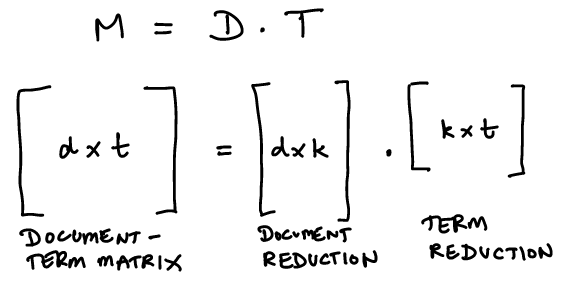

In [19]:
Image("NLP_images/DTM_reduction.png", width=500)

In [20]:
# Check for dimension reduction
data_lda.shape

(129971, 3)

In [26]:
lda.perplexity(DTM)

962.4460528706168

## Non-Negative Matrix Factorization (NMF)

- As noted above we are looking to decompose the DTM $M$ into $D \cdot T$, with common dimension of size $k$.

- We apply the Froebenius norm:

$$
f =  ||M - D \cdot T ||_F^2 = \sum_d \sum_t (M_{dt} - D_{dt} T_{dt})^2.
$$

- Let the gradient be $\nabla f$.

- We minimize $f$ by iteration. First, hold $T$ fixed and find the best $D$, then hold $D$ fixed and find the best $T$.

- If we hold $T$ fixed, and differentiate with respect to a specific $d$: $\nabla f_d = \frac{\partial f}{\partial d} \sum_d \sum_t (M_{dt}^2 - 2 M_{dt} D_{dt} T_{dt} + D_{dt}^2 T_{dt}^2) = 0$.

- We get that $\nabla f_d = \sum_t (MT^\top - DTT^\top) = 0$, which implies that

$$
MT^\top = DTT^\top
$$

- We want to choose the elements of $D$ such that
  1. The LHS is as close to the RHS as possible
  2. The elements of $D$ are non-negative, else we are not doing NMF






- Using gradients, we set up the algorithm as follows:

$$
D \leftarrow D + \eta_D [MT^\top - DTT^\top]
$$

- We can choose the learning rate $\eta_D$ in a clever way to make sure that elements of $D \geq 0$, i.e., $\eta_D = \frac{D}{DTT^\top}$, the fraction taken elementwise. So, we now get

$$
D \leftarrow D + \frac{D}{DTT^\top} [MT^\top - DTT^\top]
$$

- or, elementwise

$$
D_{dt} \leftarrow  D_{dt} \cdot \frac{M_{dt}T_{dt}^\top}{D_{dt}T_{dt}T_{dt}^\top}
$$

- This update rule ensures that $D_{dt} \geq 0, \forall d,t$.
Correspondingly, the update rule for the elements of $T$ is

$$
T_{dt} \leftarrow  T_{dt} \cdot \frac{D_{dt}^\top M_{dt}}{D_{dt} D_{dt}^\top T_{dt}}
$$

In [21]:
n_topics = 3

In [22]:
# Non-Negative Matrix Factorization Model
nmf = NMF(n_components=n_topics)
data_nmf = nmf.fit_transform(DTM)

In [23]:
data_nmf.shape

(129971, 3)

we can get more details here: https://srdas.github.io/MLBook2/24_TextAnaytics_Advanced.html#Non-negative-Matrix-Factorization-(NMF)

You can use this reduced-form matrix for document similarity (for example).

In [24]:
# Latent Semantic Indexing Model using Truncated SVD
lsi = TruncatedSVD(n_components=n_topics)
data_lsi = lsi.fit_transform(DTM)

In [25]:
data_lsi.shape

(129971, 3)

More details here: https://srdas.github.io/MLBook2/24_TextAnaytics_Advanced.html#Singular-Value-Decomposition-(SVD)